DO NOT CHANGE THIS FILE. JUST MAKE COPIES.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools

# this should be the folder containing class0 and class1
INPUT_DIR = '/content/drive/My Drive/DT2_2023/Spring 2024/Audio_models/spectro_output/NOPARAMS_1_mass_background_2sec_only_swallow_20240407'
OUTPUT_DIR = '/content/drive/My Drive/DT2_2023/Spring 2024/Audio_models/saved_models/NOPARAMS_1_2_mass_background_2sec_no_swallow_20240407'
MODEL_OUTPUT_DIR = OUTPUT_DIR+'/20240407_NOPARAMS_1_2.keras'
LOSS_OUTPUT_DIR = OUTPUT_DIR+'/loss_20240407_NOPARAMS_1_2.png'
ACC_OUTPUT_DIR = OUTPUT_DIR+'/acc_20240407_NOPARAMS_1_2.png'
CONF_OUTPUT_DIR = OUTPUT_DIR+'/conf_20240407_NOPARAMS_1_2.png'
NUM_EPOCHS = 14

Data division

In [ ]:
# Declare constants
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 16
N_CHANNELS = 3
N_CLASSES = 2

# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(INPUT_DIR),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)

# Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(INPUT_DIR),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)

Found 2219 files belonging to 2 classes.
Using 1776 files for training.
Found 2219 files belonging to 2 classes.
Using 443 files for validation.


Modelling

In [ ]:
# Create CNN model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))


model.add(tf.keras.layers.Conv2D(32, 3, strides=2, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(5, 5)))
model.add(tf.keras.layers.BatchNormalization())


model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(64, 3, strides=2, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(5, 5)))
model.add(tf.keras.layers.BatchNormalization())


model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dropout(0.5))


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())


model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))


# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'],
)


# Train model for 10 epochs, capture the history
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=valid_dataset)

Epoch 1/14
111/111 [==============================] - 22s 55ms/step - loss: 0.3967 - accuracy: 0.8333 - val_loss: 1.4604 - val_accuracy: 0.2664
Epoch 2/14
111/111 [==============================] - 6s 53ms/step - loss: 0.0744 - accuracy: 0.9747 - val_loss: 0.4654 - val_accuracy: 0.8465
Epoch 3/14
111/111 [==============================] - 6s 53ms/step - loss: 0.0669 - accuracy: 0.9797 - val_loss: 0.1221 - val_accuracy: 0.9684
Epoch 4/14
111/111 [==============================] - 6s 55ms/step - loss: 0.0344 - accuracy: 0.9893 - val_loss: 0.1314 - val_accuracy: 0.9684
Epoch 5/14
111/111 [==============================] - 6s 52ms/step - loss: 0.0259 - accuracy: 0.9921 - val_loss: 0.3994 - val_accuracy: 0.8713
Epoch 6/14
111/111 [==============================] - 6s 52ms/step - loss: 0.0170 - accuracy: 0.9966 - val_loss: 0.0162 - val_accuracy: 0.9955
Epoch 7/14
111/111 [==============================] - 6s 55ms/step - loss: 0.0270 - accuracy: 0.9910 - val_loss: 0.0044 - val_accuracy: 1.000

Evaluating

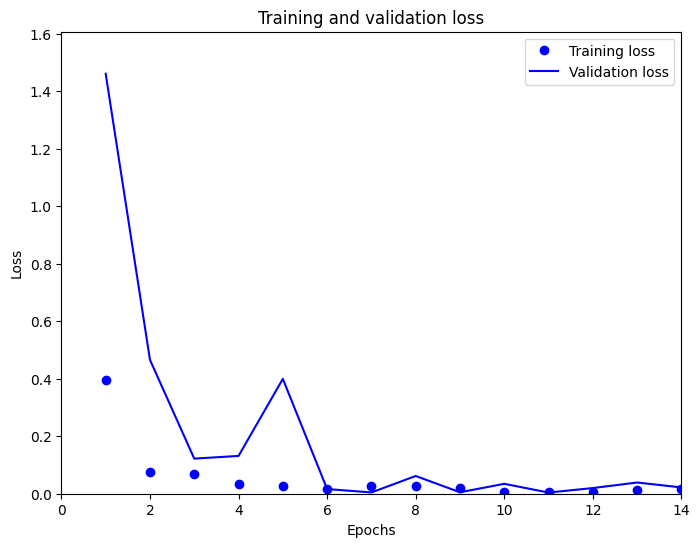

In [ ]:
# Plot the loss curves for training and validation.


history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.axis([0, NUM_EPOCHS, 0, max(max(loss_values), max(val_loss_values)) + 0.1*max(max(loss_values), max(val_loss_values))])
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(LOSS_OUTPUT_DIR)
plt.show()

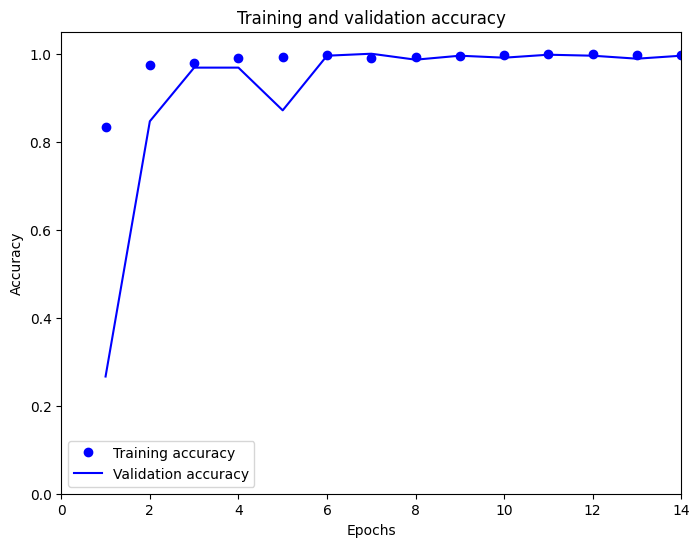

In [ ]:
# Plot the accuracy curves for training and validation.
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.axis([0, NUM_EPOCHS, 0, 1.05])
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(ACC_OUTPUT_DIR)
plt.show()

1/1 [==============================] - 0s 24ms/step


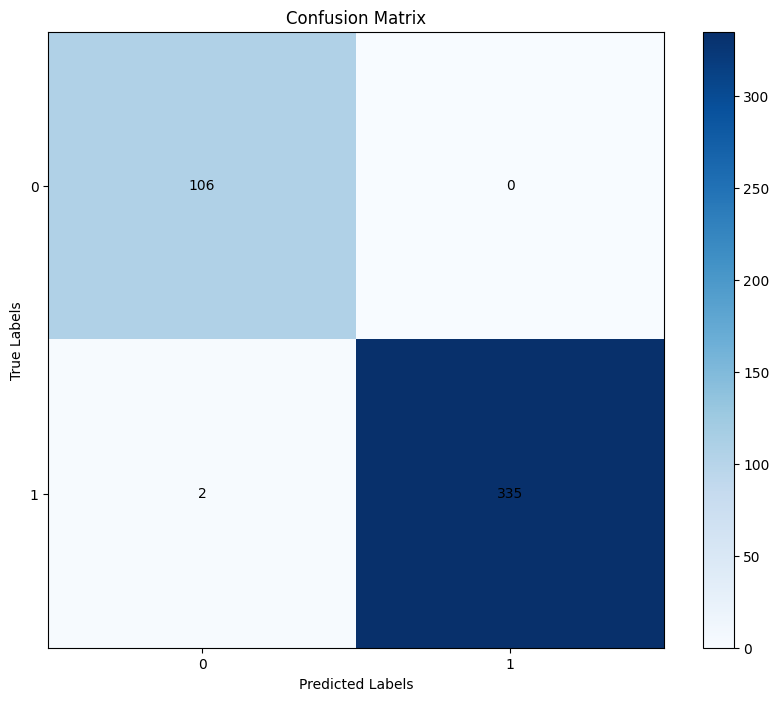

In [ ]:
# compute the confusion matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get true labels
y_true = []
y_pred = []
for images, labels in valid_dataset:
    y_true.extend(labels.numpy())
    y_pred.extend( np.argmax( model.predict(images) , axis = - 1) )

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(N_CLASSES))
plt.yticks(np.arange(N_CLASSES))
for i in range(N_CLASSES):
    for j in range(N_CLASSES):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')
plt.savefig(CONF_OUTPUT_DIR)
plt.show()

In [ ]:
# Compute the final loss and accuracy
final_loss, final_acc = model.evaluate(valid_dataset)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

28/28 [==============================] - 1s 32ms/step - loss: 0.0220 - accuracy: 0.9955
Final loss: 0.021953, final accuracy: 0.995485


Saving the model

In [ ]:
model.save(MODEL_OUTPUT_DIR)